In [ ]:
! pip install modAL-python

In [9]:
import torch
import torch.nn as nn
from transformers import AutoModel
from transformers.modeling_outputs import SequenceClassifierOutput

class BertForSentimentClassification(nn.Module):
    def __init__(self, model_name, num_labels, dropout_prob=0.1):
        super().__init__()
        self.num_labels = num_labels
        self.bert = AutoModel.from_pretrained(model_name)
        self.config = self.bert.config  # Get config from base model

        # Add dropout layer
        self.dropout = nn.Dropout(dropout_prob)

        # Add LayerNorm layer
        self.layer_norm = nn.LayerNorm(self.config.hidden_size)

        # Add classification layer
        self.classifier = nn.Linear(self.config.hidden_size, num_labels)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        # Use the pooler output for classification
        pooled_output = outputs.pooler_output if hasattr(outputs, 'pooler_output') and outputs.pooler_output is not None else outputs.last_hidden_state[:, 0]  # Fallback to CLS token

        # Apply dropout
        pooled_output = self.dropout(pooled_output)

        # Apply LayerNorm
        pooled_output = self.layer_norm(pooled_output)

        # Apply classifier
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        # Return structured output compatible with Trainer
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import seaborn as sns
from copy import deepcopy
from transformers import Trainer, TrainingArguments
from torch.utils.data import DataLoader

# Import modAL
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling, margin_sampling, entropy_sampling


# Configuration
warnings.filterwarnings("ignore")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Active learning parameters
N_INITIAL = 100       # Number of initial labeled samples
N_QUERY = 100          # Number of samples to query in each round
N_ROUNDS = 10          # Number of active learning rounds
BATCH_SIZE = 32       # Batch size for PyTorch training
LR = 1e-5             # Learning rate for transformer models
EPOCHS_PER_ROUND = 5  # Number of epochs to train in each AL round

2025-05-06 10:58:42.008127: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746529122.161399      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746529122.202996      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda


In [11]:
# --- Custom Dataset for Arabic Sentiment Classification ---
class ArabicSentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        
        # Remove batch dimension added by tokenizer
        encoding = {k: v.squeeze(0) for k, v in encoding.items()}
        encoding["labels"] = torch.tensor(label, dtype=torch.long)
        
        return encoding

# --- Random Sampling ---
def random_sampling(classifier, X_pool, n_instances=1, **kwargs):
    n_samples = len(X_pool)
    if n_samples == 0:
        raise ValueError("The pool is empty. Cannot sample from an empty pool.")
    n_instances = min(n_instances, n_samples)
    query_idx = np.random.choice(range(n_samples), size=n_instances, replace=False)
    return query_idx, X_pool[query_idx]

# --- PyTorch Wrapper for Scikit-learn/modAL Compatibility ---
class TransformerSklearnWrapper:
    def __init__(self, model_name, num_labels, tokenizer, epochs=EPOCHS_PER_ROUND, batch_size=BATCH_SIZE, device=DEVICE):
        self.model_name = model_name
        self.num_labels = num_labels
        self.tokenizer = tokenizer
        self.epochs = epochs
        self.batch_size = batch_size
        self.device = device

        # Initialize the model
        self.model = BertForSentimentClassification(model_name, num_labels).to(device)
        self.classes_ = np.arange(num_labels)  # Needed for ActiveLearner
        self.trainer = None  # Initialize trainer to None

    def fit(self, X, y):
        """
        Fit the model to the data using Hugging Face Trainer.
        X: List of text samples
        y: List of labels
        """
        # Create dataset
        dataset = ArabicSentimentDataset(X, y, self.tokenizer)

        # Define training arguments
        training_args = TrainingArguments(
            output_dir='./results',          # Directory to save results
            num_train_epochs=self.epochs,
            per_device_train_batch_size=self.batch_size,
            learning_rate=LR,
            warmup_ratio=0.1,
            weight_decay=0.02,
            logging_dir='./logs',            # Directory for logs
            logging_steps=len(dataset) // self.batch_size,
            eval_strategy="no",        # Evaluate at the end of each epoch
            report_to="none",                # Don't report to any external service
            save_total_limit=2,
            no_cuda=False,      # Set based on device
            #fp16=torch.cuda.is_available()
        )

        # Initialize Trainer
        self.trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=dataset
        )

        # Train the model
        self.trainer.train()

        return self

    def predict(self, X):
        """
        Predict class labels for samples in X using the trained model.
        X: List of text samples
        """
        self.model.eval()
        dataset = ArabicSentimentDataset(X, [0] * len(X), self.tokenizer)  # Dummy labels
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)

        all_preds = []
        with torch.no_grad():
            for batch in dataloader:
                batch = {k: v.to(self.device) for k, v in batch.items() if k != 'labels'}
                outputs = self.model(**batch)
                logits = outputs.logits
                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy())

        return np.array(all_preds)

    def predict_proba(self, X):
        """
        Predict class probabilities for samples in X using the trained model.
        X: List of text samples
        """
        self.model.eval()
        dataset = ArabicSentimentDataset(X, [0] * len(X), self.tokenizer)  # Dummy labels
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)

        all_probs = []
        with torch.no_grad():
            for batch in dataloader:
                batch = {k: v.to(self.device) for k, v in batch.items() if k != 'labels'}
                outputs = self.model(**batch)
                logits = outputs.logits
                probs = torch.nn.functional.softmax(logits, dim=1)
                all_probs.extend(probs.cpu().numpy())

        return np.array(all_probs)

    def score(self, X, y):
        """
        Return the accuracy on the given test data and labels.
        X: List of text samples
        y: List of labels
        """
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

    def clone(self):
        """
        Return a new instance of the wrapper with the same configuration.
        """
        return TransformerSklearnWrapper(
            model_name=self.model_name,
            num_labels=self.num_labels,
            tokenizer=self.tokenizer,
            epochs=self.epochs,
            batch_size=self.batch_size,
            device=self.device
        )

# --- Active Learning Function ---
def run_active_learning_experiment(
    model_name,
    tokenizer,
    X_train,
    y_train,
    X_test,
    y_test,
    num_labels=3,
    n_initial=N_INITIAL,
    n_query=N_QUERY,
    n_rounds=N_ROUNDS
):
    """
    Run active learning experiment with provided data and settings.
    """
    results = {}
    query_strategies = {
        "Random": random_sampling,
        "Least Confidence": uncertainty_sampling,
        "Margin": margin_sampling,
        "Entropy": entropy_sampling
    }

    # Split initial labeled data and unlabeled pool
    initial_indices = np.random.choice(range(len(X_train)), size=N_INITIAL, replace=False)
    pool_indices = np.setdiff1d(np.arange(len(X_train)), initial_indices)

    X_initial = [X_train[i] for i in initial_indices]
    y_initial = y_train[initial_indices]

    X_pool = np.array([X_train[i] for i in pool_indices]) 
    y_pool = y_train[pool_indices]

    print(f"Initial labeled size: {len(X_initial)}")
    print(f"Unlabeled pool size: {len(X_pool)}")
    print(f"Test set size: {len(X_test)}")

    for strategy_name, query_strategy_func in query_strategies.items():
        print(f"\n-- Strategy: {strategy_name} --")
        start_time = time.time()

        # Keep track of data for this strategy run
        current_X_train = deepcopy(X_initial)
        current_y_train = deepcopy(y_initial)
        current_X_pool = deepcopy(X_pool)
        current_y_pool = deepcopy(y_pool)

        # Create a new model instance for each strategy
        transformer_wrapper = TransformerSklearnWrapper(
            model_name=model_name,
            num_labels=num_labels,
            tokenizer=tokenizer,
            epochs=EPOCHS_PER_ROUND
        )

        # Initialize ActiveLearner
        learner = ActiveLearner(
            estimator=transformer_wrapper,
            query_strategy=query_strategy_func,
            X_training=current_X_train,
            y_training=current_y_train
        )

        strategy_accuracies = []

        print("Training on initial data...")
        learner.fit(current_X_train, current_y_train)
        initial_accuracy = learner.score(X_test, y_test)
        initial_train_accuracy = learner.score(current_X_train, current_y_train)
        print(f"Round 0 (Initial): Test Accuracy = {initial_accuracy:.4f}, Train Accuracy = {initial_train_accuracy:.4f}")
        strategy_accuracies.append(initial_accuracy)

        for round_idx in range(n_rounds):
            print(f"Round {round_idx + 1}/{n_rounds}")

            if len(current_X_pool) < n_query:
                print(f"Warning: Pool size ({len(current_X_pool)}) is smaller than query size ({n_query}). Querying remaining samples.")
                n_query_actual = len(current_X_pool)
                if n_query_actual == 0:
                    print("Pool exhausted. Stopping early.")
                    break
            else:
                n_query_actual = n_query

            # Query most informative instances
            query_idx, query_instance = learner.query(current_X_pool, n_instances=n_query_actual)
            actual_labels = current_y_pool[query_idx]

            # Add queried data to training set
            queried_X = [current_X_pool[i] for i in query_idx]
            current_X_train.extend(queried_X)
            current_y_train = np.concatenate((current_y_train, actual_labels), axis=0)

            # Remove queried data from the pool
            current_X_pool = np.delete(current_X_pool, query_idx, axis=0)
            current_y_pool = np.delete(current_y_pool, query_idx, axis=0)

            # Retrain the model on the entire updated training set
            print(f"Training on {len(current_X_train)} samples...")
            learner.estimator.fit(current_X_train, current_y_train)

            # Evaluate on test set
            round_accuracy = learner.score(X_test, y_test)
            round_train_accuracy = learner.score(current_X_train, current_y_train)
            print(f"Round {round_idx + 1}: Test Accuracy = {round_accuracy:.4f}, Train Accuracy = {round_train_accuracy:.4f}")
            strategy_accuracies.append(round_accuracy)

            # Check if pool is empty
            if len(current_X_pool) == 0:
                print("Pool exhausted. Stopping early for this strategy.")
                break

        results[strategy_name] = strategy_accuracies
        end_time = time.time()
        print(f"-- Strategy {strategy_name} completed in {end_time - start_time:.2f} seconds --")

    return results

# --- Plotting Results ---
def plot_active_learning_results(results, dataset_name, N_INITIAL, N_QUERY):
    plt.style.use('seaborn-v0_8-whitegrid')  # Use a nice style
    plt.figure(figsize=(10, 6))
    
    for strategy_name, accuracies in results.items():
        # X-axis represents the amount of labeled data: Initial + Rounds * Query Size
        data_points = np.arange(len(accuracies)) * N_QUERY + N_INITIAL
        plt.plot(data_points, accuracies, marker='o', linestyle='-', markersize=4, label=strategy_name)
    
    plt.title(f'Active Learning Performance on {dataset_name}')
    plt.xlabel('Number of Labeled Samples')
    plt.ylabel('Test Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Example Usage ---
if __name__ == "__main__":
    from transformers import AutoTokenizer
    import pandas as pd
    
    # Example code to load and preprocess your Arabic sentiment dataset
    # This is placeholder code - replace with your actual dataset loading
    
    # Load the tokenizer
    model_name = "aubmindlab/bert-base-arabertv02"  # Example Arabic BERT model
    tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/381 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/825k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Using device: cuda
Loading ArSAS dataset from Hugging Face...


README.md:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/18678 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/334k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/13074 [00:00<?, ? examples/s]

Map:   0%|          | 0/5604 [00:00<?, ? examples/s]

Map:   0%|          | 0/13074 [00:00<?, ? examples/s]

Map:   0%|          | 0/5604 [00:00<?, ? examples/s]


Running active learning experiment...
Initial labeled size: 100
Unlabeled pool size: 12974
Test set size: 5604

-- Strategy: Random --


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Step,Training Loss
3,1.081200
6,0.955000
9,0.908000


Training on initial data...


Step,Training Loss
3,0.789800
6,0.690700
9,0.647800


Round 0 (Initial): Test Accuracy = 0.6770, Train Accuracy = 0.8600
Round 1/10
Training on 200 samples...


Step,Training Loss
6,0.698900
12,0.539700
18,0.481200


Round 1: Test Accuracy = 0.7297, Train Accuracy = 0.8900
Round 2/10
Training on 300 samples...


Step,Training Loss
9,0.509700
18,0.373200


Round 2: Test Accuracy = 0.7541, Train Accuracy = 0.9500
Round 3/10
Training on 400 samples...


Step,Training Loss
12,0.359300
24,0.229400


Round 3: Test Accuracy = 0.7789, Train Accuracy = 0.9700
Round 4/10
Training on 500 samples...


Step,Training Loss
15,0.250200
30,0.143100


Round 4: Test Accuracy = 0.7832, Train Accuracy = 0.9920
Round 5/10
Training on 600 samples...


Step,Training Loss
18,0.139100
36,0.063500


Round 5: Test Accuracy = 0.7862, Train Accuracy = 0.9967
Round 6/10
Training on 700 samples...


Step,Training Loss
21,0.118200
42,0.043800


Round 6: Test Accuracy = 0.7896, Train Accuracy = 1.0000
Round 7/10
Training on 800 samples...


Step,Training Loss
25,0.084900
50,0.031700


Round 7: Test Accuracy = 0.7864, Train Accuracy = 0.9988
Round 8/10
Training on 900 samples...


Step,Training Loss
28,0.082300
56,0.027900


Round 8: Test Accuracy = 0.7885, Train Accuracy = 0.9989
Round 9/10
Training on 1000 samples...


Step,Training Loss
31,0.079500
62,0.027300


Round 9: Test Accuracy = 0.7830, Train Accuracy = 0.9990
Round 10/10
Training on 1100 samples...


Step,Training Loss
34,0.059200
68,0.012300


Round 10: Test Accuracy = 0.7891, Train Accuracy = 0.9991
-- Strategy Random completed in 985.65 seconds --

-- Strategy: Least Confidence --


Step,Training Loss
3,1.121900
6,0.930200
9,0.888800


Training on initial data...


Step,Training Loss
3,0.775500
6,0.714600
9,0.664800


Round 0 (Initial): Test Accuracy = 0.6702, Train Accuracy = 0.8500
Round 1/10
Training on 200 samples...


Step,Training Loss
6,0.820100
12,0.718700
18,0.598500


Round 1: Test Accuracy = 0.7243, Train Accuracy = 0.9000
Round 2/10
Training on 300 samples...


Step,Training Loss
9,0.665800
18,0.546100


Round 2: Test Accuracy = 0.7438, Train Accuracy = 0.9267
Round 3/10
Training on 400 samples...


Step,Training Loss
12,0.584500
24,0.402100


Round 3: Test Accuracy = 0.7734, Train Accuracy = 0.9725
Round 4/10
Training on 500 samples...


Step,Training Loss
15,0.437300
30,0.284700


Round 4: Test Accuracy = 0.7853, Train Accuracy = 0.9800
Round 5/10
Training on 600 samples...


Step,Training Loss
18,0.361900
36,0.210100


Round 5: Test Accuracy = 0.7975, Train Accuracy = 0.9867
Round 6/10
Training on 700 samples...


Step,Training Loss
21,0.262600
42,0.130900


Round 6: Test Accuracy = 0.8009, Train Accuracy = 0.9914
Round 7/10
Training on 800 samples...


Step,Training Loss
25,0.221400
50,0.108700


Round 7: Test Accuracy = 0.7980, Train Accuracy = 0.9912
Round 8/10
Training on 900 samples...


Step,Training Loss
28,0.176600
56,0.074600


Round 8: Test Accuracy = 0.8012, Train Accuracy = 0.9956
Round 9/10
Training on 1000 samples...


Step,Training Loss
31,0.133200
62,0.051500


Round 9: Test Accuracy = 0.8005, Train Accuracy = 0.9960
Round 10/10
Training on 1100 samples...


Step,Training Loss
34,0.109800
68,0.041100


Round 10: Test Accuracy = 0.8053, Train Accuracy = 0.9973
-- Strategy Least Confidence completed in 1928.40 seconds --

-- Strategy: Margin --


Step,Training Loss
3,1.121900
6,0.930200
9,0.888800


Training on initial data...


Step,Training Loss
3,0.775500
6,0.714600
9,0.664800


Round 0 (Initial): Test Accuracy = 0.6702, Train Accuracy = 0.8500
Round 1/10
Training on 200 samples...


Step,Training Loss
6,0.812200
12,0.749500
18,0.674400


Round 1: Test Accuracy = 0.7123, Train Accuracy = 0.8550
Round 2/10
Training on 300 samples...


Step,Training Loss
9,0.654800
18,0.513200


Round 2: Test Accuracy = 0.7470, Train Accuracy = 0.9133
Round 3/10
Training on 400 samples...


Step,Training Loss
12,0.497300
24,0.348800


Round 3: Test Accuracy = 0.7691, Train Accuracy = 0.9700
Round 4/10
Training on 500 samples...


Step,Training Loss
15,0.357200
30,0.222700


Round 4: Test Accuracy = 0.7825, Train Accuracy = 0.9840
Round 5/10
Training on 600 samples...


Step,Training Loss
18,0.303800
36,0.177100


Round 5: Test Accuracy = 0.7868, Train Accuracy = 0.9900
Round 6/10
Training on 700 samples...


Step,Training Loss
21,0.203700
42,0.113100


Round 6: Test Accuracy = 0.7910, Train Accuracy = 0.9943
Round 7/10
Training on 800 samples...


Step,Training Loss
25,0.165500
50,0.082300


Round 7: Test Accuracy = 0.7951, Train Accuracy = 0.9950
Round 8/10
Training on 900 samples...


Step,Training Loss
28,0.156200
56,0.076600


Round 8: Test Accuracy = 0.7971, Train Accuracy = 0.9967
Round 9/10
Training on 1000 samples...


Step,Training Loss
31,0.150000
62,0.055400


Round 9: Test Accuracy = 0.8059, Train Accuracy = 0.9960
Round 10/10
Training on 1100 samples...


Step,Training Loss
34,0.121900
68,0.062100


Round 10: Test Accuracy = 0.8021, Train Accuracy = 0.9973
-- Strategy Margin completed in 1928.45 seconds --

-- Strategy: Entropy --


Step,Training Loss
3,1.121900
6,0.930200
9,0.888800


Training on initial data...


Step,Training Loss
3,0.775500
6,0.714600
9,0.664800


Round 0 (Initial): Test Accuracy = 0.6702, Train Accuracy = 0.8500
Round 1/10
Training on 200 samples...


Step,Training Loss
6,0.826100
12,0.688100
18,0.595000


Round 1: Test Accuracy = 0.7223, Train Accuracy = 0.8850
Round 2/10
Training on 300 samples...


Step,Training Loss
9,0.676800
18,0.541800


Round 2: Test Accuracy = 0.7555, Train Accuracy = 0.8967
Round 3/10
Training on 400 samples...


Step,Training Loss
12,0.564700
24,0.393400


Round 3: Test Accuracy = 0.7784, Train Accuracy = 0.9775
Round 4/10
Training on 500 samples...


Step,Training Loss
15,0.438300
30,0.285100


Round 4: Test Accuracy = 0.7926, Train Accuracy = 0.9860
Round 5/10
Training on 600 samples...


Step,Training Loss
18,0.351100
36,0.181400


Round 5: Test Accuracy = 0.7955, Train Accuracy = 0.9900
Round 6/10
Training on 700 samples...


Step,Training Loss
21,0.281300
42,0.129400


Round 6: Test Accuracy = 0.7910, Train Accuracy = 0.9986
Round 7/10
Training on 800 samples...


Step,Training Loss
25,0.224500
50,0.108100


Round 7: Test Accuracy = 0.7982, Train Accuracy = 0.9962
Round 8/10
Training on 900 samples...


Step,Training Loss
28,0.218200
56,0.091900


Round 8: Test Accuracy = 0.7973, Train Accuracy = 0.9956
Round 9/10
Training on 1000 samples...


Step,Training Loss
31,0.160000
62,0.067800


Round 9: Test Accuracy = 0.8023, Train Accuracy = 0.9930
Round 10/10
Training on 1100 samples...


Step,Training Loss
34,0.150600
68,0.062500


Round 10: Test Accuracy = 0.8007, Train Accuracy = 0.9945
-- Strategy Entropy completed in 1927.80 seconds --


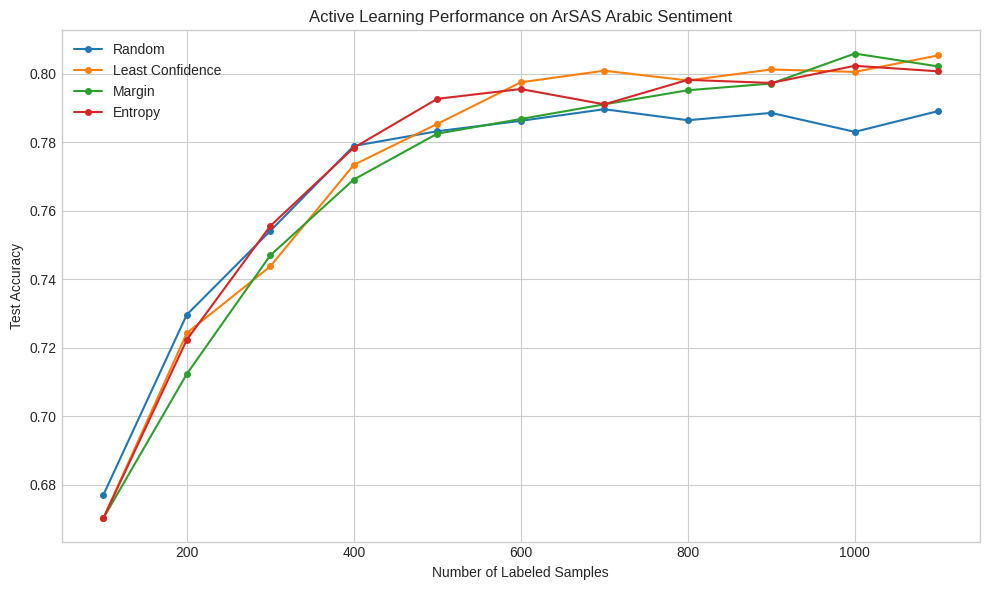

In [12]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from datasets import load_dataset
import matplotlib.pyplot as plt


# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

def main():
    print("Loading ArSAS dataset from Hugging Face...")
    ds = load_dataset("Qanadil/ArSAS_An_Arabic_Speech-Act_and_Sentiment_Corpus_of_Tweets")
    split_ds = ds['train'].train_test_split(test_size=0.3, seed=42)

    train_ds_hf = split_ds['train']
    val_ds_hf = split_ds['test']

    model_name = "asafaya/bert-base-arabic"
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    def tokenize(example):
        return tokenizer(example["Tweet_text"], truncation=True, padding="max_length", max_length=512)

    train_ds = train_ds_hf.map(tokenize, batched=True)
    val_ds = val_ds_hf.map(tokenize, batched=True)

    def fix_labels(example):
        label_mapping = {"Positive": 0, "Neutral": 1, "Negative": 2}
        example["Sentiment_label"] = label_mapping[example["Sentiment_label"]]
        return example

    # Apply the label fix
    train_ds = train_ds.map(fix_labels)
    val_ds = val_ds.map(fix_labels)

    train_ds = train_ds.rename_column("Sentiment_label", "labels")
    val_ds = val_ds.rename_column("Sentiment_label", "labels")

    train_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
    val_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

    # Convert to lists of texts and NumPy arrays of labels
    X_train_full = [item['Tweet_text'] for item in train_ds_hf]
    y_train_full = train_ds['labels'].cpu().numpy()
    X_test = [item['Tweet_text'] for item in val_ds_hf]
    y_test = val_ds['labels'].cpu().numpy()

    print("\nRunning active learning experiment...")
    results = run_active_learning_experiment(
        model_name=model_name,
        tokenizer=tokenizer,
        X_train=X_train_full,
        y_train=y_train_full,
        X_test=X_test,
        y_test=y_test,
        num_labels=3,  # 3 classes: positive, neutral, negative
        n_initial=N_INITIAL,
        n_query=N_QUERY,
        n_rounds=N_ROUNDS
    )

    # Plot results
    plot_active_learning_results(results, "ArSAS Arabic Sentiment", N_INITIAL, N_QUERY)

if __name__ == "__main__":
    main()